In [1]:
# Install necessary libraries
!pip install -q transformers datasets evaluate torchaudio librosa

# Import libraries
import os
import pandas as pd
import numpy as np
import librosa
import torch
from datasets import Dataset, Audio
from transformers import (
    AutoFeatureExtractor,
    Wav2Vec2ForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate

print("Libraries imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━

2025-08-25 06:18:35.057117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756102715.373295      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756102715.464253      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported successfully!


In [2]:
# --- Configuration ---
DATASET_PATH = "/kaggle/input/cremad/AudioWAV/"
MODEL_CHECKPOINT = "facebook/wav2vec2-base" # The pre-trained model we will use
BATCH_SIZE = 8 # Adjust if you run out of memory

# --- Emotion Mapping ---
# Map emotion abbreviations from the dataset to human-readable labels and numeric IDs
emotion_map = {
    'NEU': 'neutral',
    'HAP': 'happy',
    'SAD': 'sad',
    'ANG': 'angry',
    'FEA': 'fear',
    'DIS': 'disgust'
}

# Create mappings between integer IDs and string labels for the model
labels = list(emotion_map.values())
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}

# --- Load Data ---
def load_crema_d_dataset(directory):
    data = {"path": [], "emotion": []}
    for filename in os.listdir(directory):
        if filename.endswith(".wav"):
            try:
                # Filename format: 1001_IEO_HAP_HI.wav
                emotion_abbr = filename.split('_')[2]
                if emotion_abbr in emotion_map:
                    data["path"].append(os.path.join(directory, filename))
                    data["emotion"].append(emotion_map[emotion_abbr])
            except IndexError:
                # Skip files with unexpected naming conventions
                continue
    return pd.DataFrame(data)

# Create the dataframe and then the Dataset object
df = load_crema_d_dataset(DATASET_PATH)
dataset = Dataset.from_pandas(df)

# We need to cast the 'emotion' column to a ClassLabel type
dataset = dataset.class_encode_column("emotion")

print("Dataset loaded and prepared:")
print(dataset)
print("\nExample entry:")
print(dataset[0])

Casting to class labels:   0%|          | 0/7442 [00:00<?, ? examples/s]

Dataset loaded and prepared:
Dataset({
    features: ['path', 'emotion'],
    num_rows: 7442
})

Example entry:
{'path': '/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav', 'emotion': 1}


In [4]:
# Load the feature extractor for the chosen model
feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_CHECKPOINT)
TARGET_SAMPLING_RATE = feature_extractor.sampling_rate

# Define the preprocessing function
def preprocess_function(examples):
    # Load audio files and resample them to the target sampling rate
    audio_arrays = [librosa.load(path, sr=TARGET_SAMPLING_RATE)[0] for path in examples["path"]]
    
    # Process the audio arrays with the feature extractor
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=TARGET_SAMPLING_RATE,
        max_length=int(TARGET_SAMPLING_RATE * 5), # Pad/truncate to 5 seconds
        truncation=True,
        padding=True
    )
    
    # Map the text labels to integer IDs
    inputs["label"] = examples["emotion"]
    return inputs

# Apply the preprocessing to the entire dataset
# This is done lazily, so it's very memory efficient.
processed_dataset = dataset.map(preprocess_function, remove_columns=["path", "emotion"], batched=True)

# Split the dataset into training and testing sets (90% train, 10% test)
processed_dataset = processed_dataset.train_test_split(train_size=0.9, seed=42)

print("\nDataset after preprocessing and splitting:")
print(processed_dataset)

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Map:   0%|          | 0/7442 [00:00<?, ? examples/s]


Dataset after preprocessing and splitting:
DatasetDict({
    train: Dataset({
        features: ['input_values', 'label'],
        num_rows: 6697
    })
    test: Dataset({
        features: ['input_values', 'label'],
        num_rows: 745
    })
})


In [12]:
# Load the pre-trained model with a sequence classification head
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=len(labels),
    label2id=label2id,
    id2label=id2label,
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=50,                 # Evaluate every 50 steps
    save_strategy="no",
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,              # Log every 10 steps
    report_to="none",              # No WandB, just console
    load_best_model_at_end=False,
)
# Define the evaluation metric (accuracy)
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=eval_pred.label_ids)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

# Start training!
print("Starting the fine-tuning process...")
trainer.train()
print("Training complete!")

/tmp/ipykernel_36/1043984115.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting the fine-tuning process...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,1.751000,1.744092,0.316779
100,1.660600,1.628990,0.346309
150,1.634800,1.602855,0.335570
200,1.578500,1.522716,0.391946
250,1.505000,1.482030,0.393289
300,1.486600,1.479302,0.404027
350,1.531800,1.483769,0.416107
400,1.499000,1.500657,0.409396
450,1.453700,1.382066,0.467114
500,1.468500,1.350233,0.499329


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

Training complete!


In [14]:
# Evaluate the model on the test set
evaluation_results = trainer.evaluate()

print("\n--- Final Evaluation Results ---")
print(f"Accuracy: {evaluation_results['eval_accuracy']:.4f}")
print("------------------------------")


--- Final Evaluation Results ---
Accuracy: 0.7705
------------------------------


In [17]:
# After training is complete
model_save_path = "./wav2vec2_finetuned_model"

# Save the model
trainer.save_model(model_save_path)

# Save the tokenizer/feature extractor too
feature_extractor.save_pretrained(model_save_path)

print(f"Model and feature extractor saved to {model_save_path}")

trainer.state.save_to_json("./trainer_state.json")


Model and feature extractor saved to ./wav2vec2_finetuned_model


In [ ]:
import os
from transformers import pipeline

# 1. Use the exact path to your saved model in Kaggle
MODEL_PATH = "/kaggle/working/wav2vec2_finetuned_model"

print(f"Loading model from: {MODEL_PATH}")

# 2. Load the classifier from your saved files
# The pipeline function automatically reads all the necessary files from this folder.
finetuned_classifier = pipeline(
    "audio-classification",
    model=MODEL_PATH
)

def get_emotion_probabilities(audio_path):
    """
    Takes an audio file path and returns a dictionary of emotion probabilities.
    """
    if not os.path.exists(audio_path):
        return {"error": f"Audio file not found at: {audio_path}"}

    # The pipeline handles all preprocessing
    # The 'top_k' argument ensures we get scores for all 6 of your emotion classes.
    predictions = finetuned_classifier(audio_path, top_k=6)
    
    # Format the output into a clean dictionary
    probabilities = {p['label'].lower(): round(p['score'], 4) for p in predictions}
    
    return probabilities

# --- Example Usage ---
# 3. Provide a path to a test audio file that is also in your Kaggle environment.
# We can use an example from the original dataset.
example_audio_path_angry = "/kaggle/input/happyaudio/happy_audio.wav" # Angry file
example_audio_path_happy = "/kaggle/input/data3set/nervous_audio1.wav"  # Happy file

# Get and print the emotion probabilities for the angry file
emotion_probs_angry = get_emotion_probabilities(example_audio_path_angry)
print(f"\nEmotion probabilities for: {os.path.basename(example_audio_path_angry)}")
print(emotion_probs_angry)

# Get and print the emotion probabilities for the happy file
emotion_probs_happy = get_emotion_probabilities(example_audio_path_happy)
print(f"\nEmotion probabilities for: {os.path.basename(example_audio_path_happy)}")
print(emotion_probs_happy)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


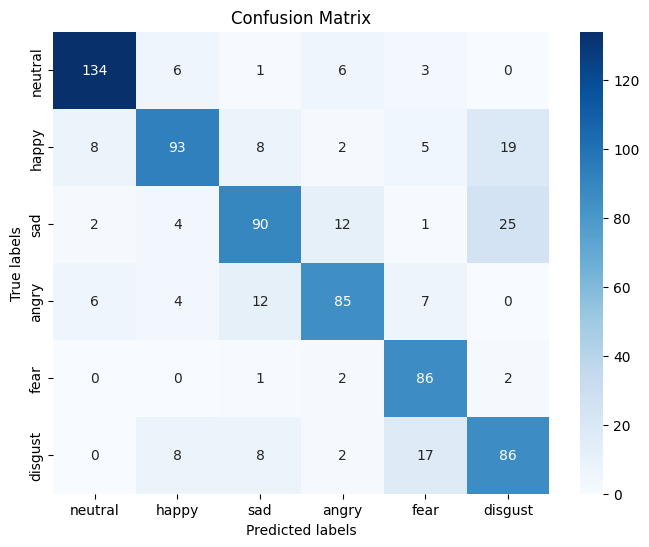

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get predictions from the trainer on the test set
predictions = trainer.predict(processed_dataset["test"])
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()
